# Tools and Routing

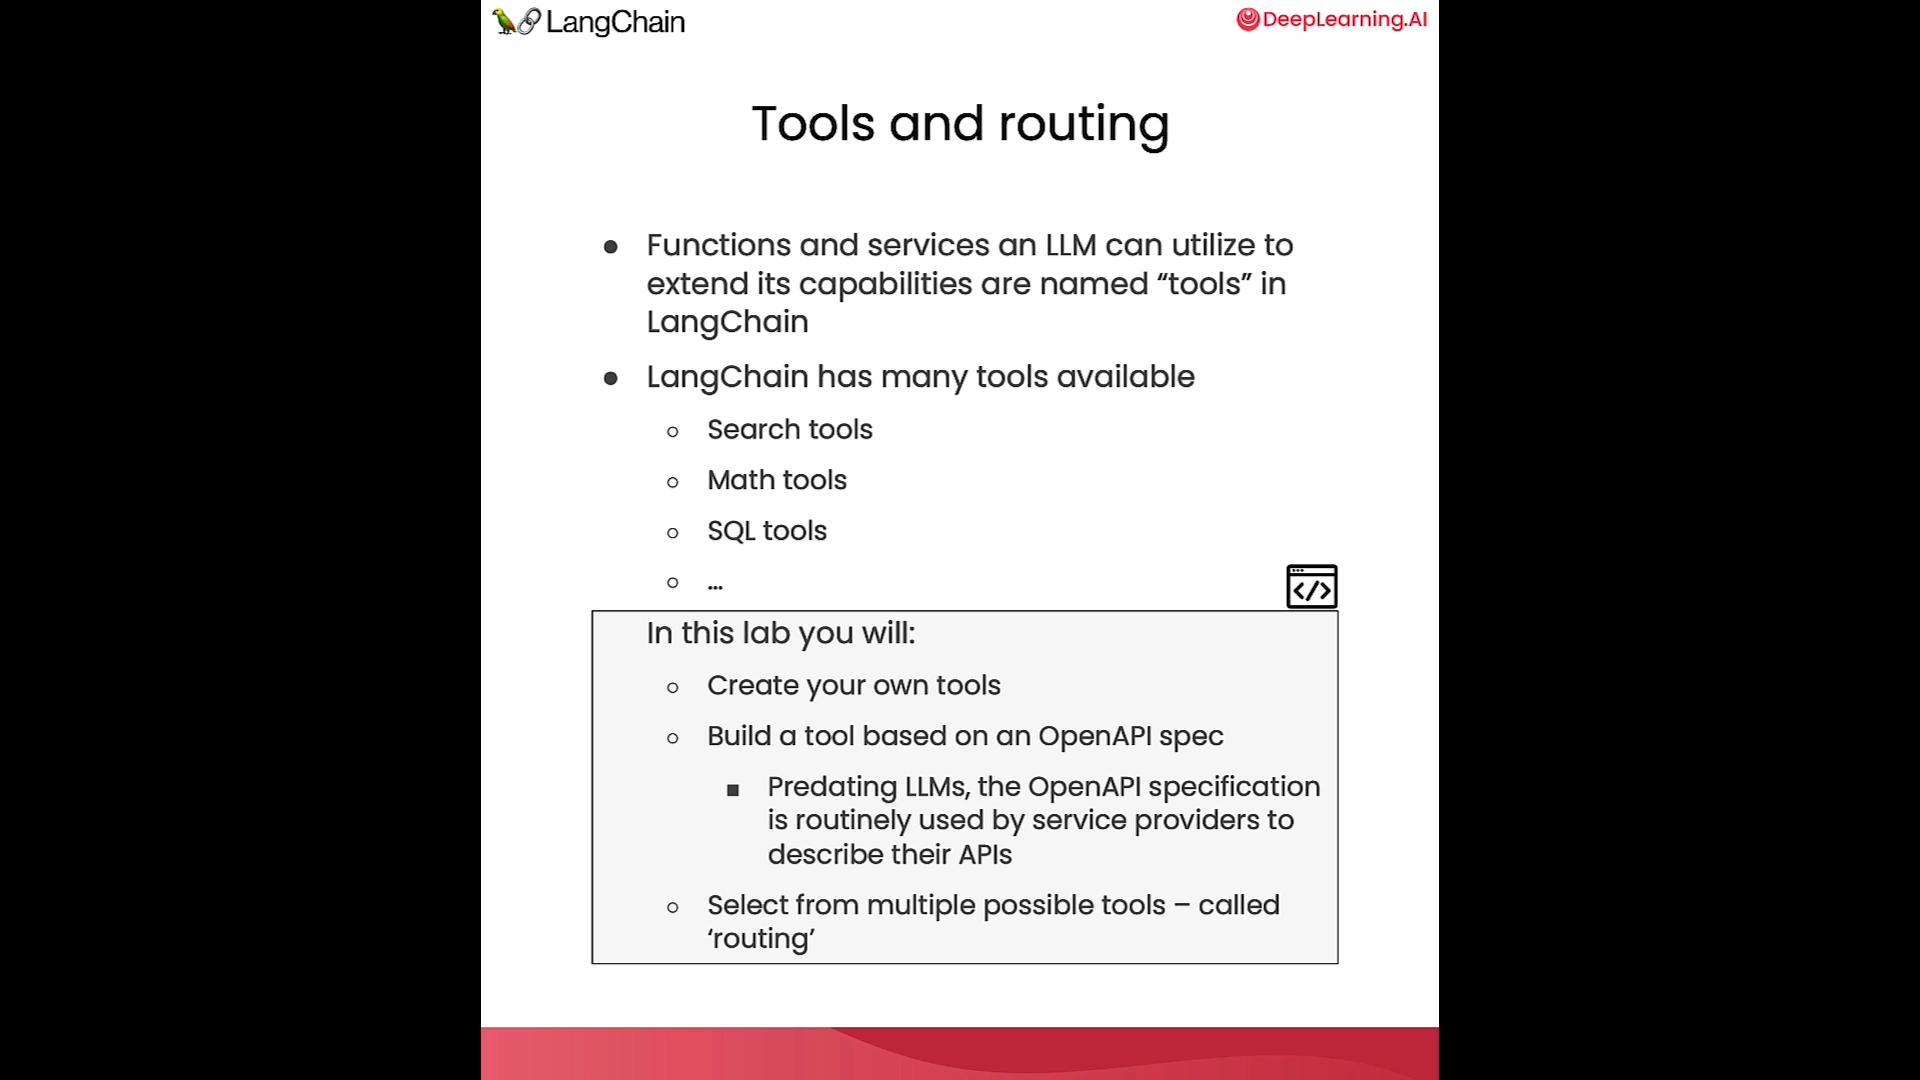

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
from langchain.agents import tool ## This converts function to langchain tool

In [3]:
@tool
def search(query: str) -> str:
    """Search for weather online"""
    return "42f"

In [4]:
search.name

'search'

In [5]:
search.description

'search(query: str) -> str - Search for weather online'

In [6]:
search.args

{'query': {'title': 'Query', 'type': 'string'}}

Combine Pydantic and Lanhchain Tools

In [7]:
from pydantic import BaseModel, Field
class SearchInput(BaseModel):
    query: str = Field(description="Thing to search for")


In [9]:
@tool(args_schema=SearchInput)
def search(query: str) -> str:
    """Search for the weather online."""
    return "42f"

In [10]:
search.args

{'query': {'title': 'Query',
  'description': 'Thing to search for',
  'type': 'string'}}

In [11]:
search.run("sf")

'42f'

In [12]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [13]:
get_current_temperature.name

'get_current_temperature'

In [14]:
get_current_temperature.description

'get_current_temperature(latitude: float, longitude: float) -> dict - Fetch current temperature for given coordinates.'

In [15]:
get_current_temperature.args

{'latitude': {'title': 'Latitude',
  'description': 'Latitude of the location to fetch weather data for',
  'type': 'number'},
 'longitude': {'title': 'Longitude',
  'description': 'Longitude of the location to fetch weather data for',
  'type': 'number'}}

In [16]:
from langchain.tools.render import format_tool_to_openai_function

In [17]:
format_tool_to_openai_function(get_current_temperature)

{'name': 'get_current_temperature',
 'description': 'get_current_temperature(latitude: float, longitude: float) -> dict - Fetch current temperature for given coordinates.',
 'parameters': {'title': 'OpenMeteoInput',
  'type': 'object',
  'properties': {'latitude': {'title': 'Latitude',
    'description': 'Latitude of the location to fetch weather data for',
    'type': 'number'},
   'longitude': {'title': 'Longitude',
    'description': 'Longitude of the location to fetch weather data for',
    'type': 'number'}},
  'required': ['latitude', 'longitude']}}

In [18]:
get_current_temperature({"latitude": 13, "longitude": 14})

'The current temperature is 14.3°C'

In [19]:
import wikipedia
@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [20]:
search_wikipedia.name

'search_wikipedia'

In [21]:
search_wikipedia.description

'search_wikipedia(query: str) -> str - Run Wikipedia search and get page summaries.'

In [22]:
format_tool_to_openai_function(search_wikipedia)

{'name': 'search_wikipedia',
 'description': 'search_wikipedia(query: str) -> str - Run Wikipedia search and get page summaries.',
 'parameters': {'title': 'search_wikipediaSchemaSchema',
  'type': 'object',
  'properties': {'query': {'title': 'Query', 'type': 'string'}},
  'required': ['query']}}

In [23]:
search_wikipedia({"query": "langchain"})

'Page: LangChain\nSummary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain\'s use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\nPage: OpenAI\nSummary: OpenAI is a U.S. artificial intelligence (AI) research organization founded in December 2015, researching artificial intelligence with the declared intention of developing "safe and beneficial" artificial general intelligence, which it defines as "highly autonomous systems that outperform humans at most economically valuable work".\nAs one of the leading organizations of the AI Spring, it has developed several large language models, advanced image generation models, and previously, also open-source models. Its release of ChatGPT has been credited with starting the artificial intelligence spring.The organization consists of the n

In [24]:
from langchain.chains.openai_functions.openapi import openapi_spec_to_openai_fn
from langchain.utilities.openapi import OpenAPISpec

In [25]:
text = """
{
  "openapi": "3.0.0",
  "info": {
    "version": "1.0.0",
    "title": "Swagger Petstore",
    "license": {
      "name": "MIT"
    }
  },
  "servers": [
    {
      "url": "http://petstore.swagger.io/v1"
    }
  ],
  "paths": {
    "/pets": {
      "get": {
        "summary": "List all pets",
        "operationId": "listPets",
        "tags": [
          "pets"
        ],
        "parameters": [
          {
            "name": "limit",
            "in": "query",
            "description": "How many items to return at one time (max 100)",
            "required": false,
            "schema": {
              "type": "integer",
              "maximum": 100,
              "format": "int32"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "A paged array of pets",
            "headers": {
              "x-next": {
                "description": "A link to the next page of responses",
                "schema": {
                  "type": "string"
                }
              }
            },
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Pets"
                }
              }
            }
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      },
      "post": {
        "summary": "Create a pet",
        "operationId": "createPets",
        "tags": [
          "pets"
        ],
        "responses": {
          "201": {
            "description": "Null response"
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      }
    },
    "/pets/{petId}": {
      "get": {
        "summary": "Info for a specific pet",
        "operationId": "showPetById",
        "tags": [
          "pets"
        ],
        "parameters": [
          {
            "name": "petId",
            "in": "path",
            "required": true,
            "description": "The id of the pet to retrieve",
            "schema": {
              "type": "string"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "Expected response to a valid request",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Pet"
                }
              }
            }
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      }
    }
  },
  "components": {
    "schemas": {
      "Pet": {
        "type": "object",
        "required": [
          "id",
          "name"
        ],
        "properties": {
          "id": {
            "type": "integer",
            "format": "int64"
          },
          "name": {
            "type": "string"
          },
          "tag": {
            "type": "string"
          }
        }
      },
      "Pets": {
        "type": "array",
        "maxItems": 100,
        "items": {
          "$ref": "#/components/schemas/Pet"
        }
      },
      "Error": {
        "type": "object",
        "required": [
          "code",
          "message"
        ],
        "properties": {
          "code": {
            "type": "integer",
            "format": "int32"
          },
          "message": {
            "type": "string"
          }
        }
      }
    }
  }
}
"""

In [26]:
spec = OpenAPISpec.from_text(text)

Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.


In [27]:
spec

OpenAPISpec(openapi='3.0.0', info=Info(title='Swagger Petstore', summary=None, description=None, termsOfService=None, contact=None, license=License(name='MIT', identifier=None, url=None), version='1.0.0'), jsonSchemaDialect=None, servers=[Server(url='http://petstore.swagger.io/v1', description=None, variables=None)], paths={'/pets': PathItem(ref=None, summary=None, description=None, get=Operation(tags=['pets'], summary='List all pets', description=None, externalDocs=None, operationId='listPets', parameters=[Parameter(name='limit', param_in='query', description='How many items to return at one time (max 100)', required=False, deprecated=False, allowEmptyValue=False, style=None, explode=False, allowReserved=False, param_schema=Schema(allOf=None, anyOf=None, oneOf=None, schema_not=None, schema_if=None, then=None, schema_else=None, dependentSchemas=None, prefixItems=None, items=None, contains=None, properties=None, patternProperties=None, additionalProperties=None, propertyNames=None, unev

In [28]:
pet_openai_functions, pet_callables = openapi_spec_to_openai_fn(spec)

In [29]:
pet_openai_functions

[{'name': 'listPets',
  'description': 'List all pets',
  'parameters': {'type': 'object',
   'properties': {'params': {'type': 'object',
     'properties': {'limit': {'type': 'integer',
       'maximum': 100.0,
       'schema_format': 'int32',
       'description': 'How many items to return at one time (max 100)'}},
     'required': []}}}},
 {'name': 'createPets',
  'description': 'Create a pet',
  'parameters': {'type': 'object', 'properties': {}}},
 {'name': 'showPetById',
  'description': 'Info for a specific pet',
  'parameters': {'type': 'object',
   'properties': {'path_params': {'type': 'object',
     'properties': {'petId': {'type': 'string',
       'description': 'The id of the pet to retrieve'}},
     'required': ['petId']}}}}]

In [30]:
from langchain.chat_models import ChatOpenAI

In [31]:
model = ChatOpenAI(temperature=0).bind(functions=pet_openai_functions)

In [32]:
model.invoke("what are three pets names")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'listPets', 'arguments': '{\n  "params": {\n    "limit": 3\n  }\n}'}})

In [33]:
model.invoke("tell me about pet with id 42")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'showPetById', 'arguments': '{\n  "path_params": {\n    "petId": "42"\n  }\n}'}})

### Routing

In lesson 3, we show an example of function calling deciding between two candidate functions.

Given our tools above, let's format these as OpenAI functions and show this same behavior.

In [34]:
functions = [
    format_tool_to_openai_function(f) for f in [
        search_wikipedia, get_current_temperature
    ]
]
model = ChatOpenAI(temperature=0).bind(functions=functions)

In [35]:
model.invoke("what is the weather in sf right now")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}'}})

In [36]:
model.invoke("what is langchain")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_wikipedia', 'arguments': '{\n  "query": "langchain"\n}'}})

In [37]:
from langchain.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model

In [38]:
chain.invoke({"input": "what is the weather in sf right now"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}'}})

In [39]:
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [40]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [41]:
result = chain.invoke({"input": "what is the weather in sf right now"})

In [44]:
result

AgentActionMessageLog(tool='get_current_temperature', tool_input={'latitude': 37.7749, 'longitude': -122.4194}, log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}'}})])

In [42]:
type(result)

langchain.schema.agent.AgentActionMessageLog

In [45]:
result.tool

'get_current_temperature'

In [46]:
result.tool_input

{'latitude': 37.7749, 'longitude': -122.4194}

In [47]:
get_current_temperature(result.tool_input)

'The current temperature is 11.7°C'

In [48]:
result = chain.invoke({"input": "hi!"})

In [49]:
type(result)

langchain.schema.agent.AgentFinish

In [50]:
result.return_values

{'output': 'Hello! How can I assist you today?'}

In [51]:
from langchain.schema.agent import AgentFinish
def route(result):
    if isinstance(result, AgentFinish):
        return result.return_values['output']
    else:
        tools = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }
        return tools[result.tool].run(result.tool_input)

In [52]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser() | route

In [53]:
result = chain.invoke({"input": "What is the weather in san francisco right now?"})

In [54]:
result

'The current temperature is 11.7°C'

In [55]:
result = chain.invoke({"input": "What is langchain?"})

In [56]:
result

'Page: LangChain\nSummary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain\'s use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\nPage: OpenAI\nSummary: OpenAI is a U.S. artificial intelligence (AI) research organization founded in December 2015, researching artificial intelligence with the declared intention of developing "safe and beneficial" artificial general intelligence, which it defines as "highly autonomous systems that outperform humans at most economically valuable work".\nAs one of the leading organizations of the AI Spring, it has developed several large language models, advanced image generation models, and previously, also open-source models. Its release of ChatGPT has been credited with starting the artificial intelligence spring.The organization consists of the n

In [57]:
chain.invoke({"input": "hi!"})

'Hello! How can I assist you today?'